# Phytoplankton biomass
<div>
<img src="https://img.pagecloud.com/nXOUkUjhhkla7tj6dosu06sE0-I=/1398x0/filters:no_upscale()/scientific-illustrations-by-kristen/images/cocco_in_blue_v2-lc467.png" width="500"/>
</div>

A coccolithophore, a type of phytoplankton. Art credit: [Kristen Krumhardt](https://www.earthaliveillos.com/)

---

## Overview
There are several different types of phytoplankton that are prevalent in different parts of the ocean. In this notebook, we evaluate the biomass and total production of these phytoplankton in different areas, as modeled by CESM-MARBL.

1. General setup
2. Subsetting
3. Taking a quick look
4. Processing data
5. Mapping biomass at different depths
6. Mapping productivity
7. Compare NPP to satellite observations
   
TO DO: Add comparison of NPP to cloud based satellite obs, add more narrative text, clean up comments, add references

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Dask Cookbook](https://projectpythia.org/dask-cookbook/README.html) | Helpful | |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray.html) | Helpful | |
| [Matplotlib](https://foundations.projectpythia.org/core/matplotlib.html) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Necessary | |

- **Time to learn**: 30 min


---

## Imports

In [1]:
import xarray as xr
import glob
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools
import copernicusmarine as copernicus_marine
from dask.distributed import LocalCluster

## General setup (see intro notebooks for explanations)

### Connect to cluster

In [2]:
cluster = LocalCluster()
client = cluster.get_client()

/glade/work/eromashkova/miniconda3/envs/ocean-bgc-cookbook-dev/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46689 instead
  warnings.warn(


### Bring in POP grid utilities

In [3]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
depths = ds_grid.z_t * 0.01

In [4]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    # Trick cartopy into doing the right thing:
    # it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8
    
    # Periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

### Load the data

In [5]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/'+case+'/ocn/proc/tseries/month_1'
coords = {'x':'TLONG','y':'TLAT'}
path

'/glade/derecho/scratch/eromashkova/ocean-bgc-cookbook-data/cesm/g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch/ocn/proc/tseries/month_1'

In [6]:
files = glob.glob(f'{path}/{case}.pop.h.*.195801-202112.nc')
ds=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True,
                       drop_variables=["transport_components", "transport_regions", 'moc_components'], decode_times=True)
ds

<xarray.Dataset> Size: 182GB
Dimensions:                         (nlat: 384, nlon: 320, time: 768, z_t: 60,
                                     z_w: 60, lat_aux_grid: 395, moc_z: 61,
                                     d2: 2, z_t_150m: 15, z_w_bot: 60,
                                     z_w_top: 60)
Coordinates:
    TLAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                            (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lat_aux_grid                    (lat_aux_grid) float32 2kB -79.49 ... 90.0
  * moc_z                           (moc_z) float32 244B 0.0 1e+03 ... 5.5e+05
  * time                            (time) object 6kB 1958-02-01 00:00:00 ......
  * z_t                             (z_t) float32 240B 500.0 ... 5.375e+05
  * z_t_150m                        (z_t_150m) float32 60B 500.0 ... 1.45e+04
  * z_w                             (z_w) float32 240B 0.0 1e+03 ... 5.25e+05
  * z_w_bot                         (z_w_bot) float32 240B 1e+03 ... 5.5e+05
  * z_w_top                         (z_w_top) float32 240B 0.0 ... 5.25e+05
Dimensions without coordinates: nlat, nlon, d2
Data variables: (12/96)
    ANGLE                           (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET                          (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXT                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYU                             (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                              ...
    sp_Fe_lim_Cweight_avg_100m      (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_Fe_lim_surf                  (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_N_lim_Cweight_avg_100m       (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_N_lim_surf                   (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_P_lim_Cweight_avg_100m       (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
    sp_P_lim_surf                   (time, nlat, nlon) float32 377MB dask.array<chunksize=(81, 124, 104), meta=np.ndarray>
Attributes:
    title:             g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch
    history:           Wed Jun 21 08:37:09 2023: ncks -O -4 -L 1 /glade/scrat...
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2023-06-13 at 16:35:05.0
    cell_methods:      cell_methods = time: mean ==> the variable values are ...
    NCO:               netCDF Operators version 5.1.4 (Homepage = http://nco....

## Subsetting

In [7]:
variables =['diatC', 'coccoC','spC','diazC',
            'photoC_TOT_zint',
            'photoC_sp_zint','photoC_diat_zint',
            'photoC_diaz_zint','photoC_cocco_zint']
keep_vars=['z_t','z_t_150m','dz','time_bound', 'time', 'TAREA','TLAT','TLONG'] + variables
ds = ds.drop_vars([v for v in ds.variables if v not in keep_vars])

## Taking a quick look

This looks different between winter and summer! Also note something about the coccolithophore belt in the Southern ocean. (Improve comment)

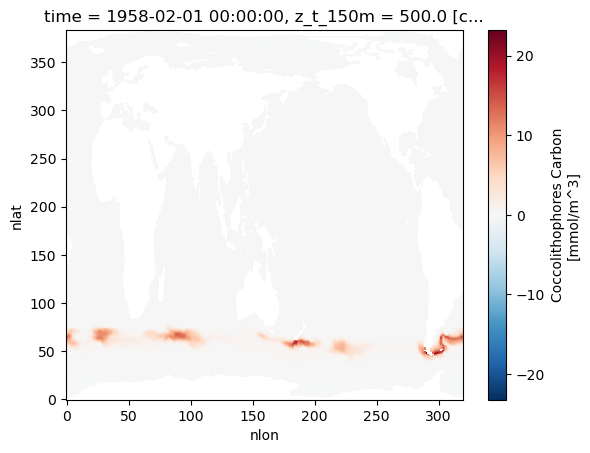

In [8]:
ds.coccoC.isel(time=0,z_t_150m=0).plot()

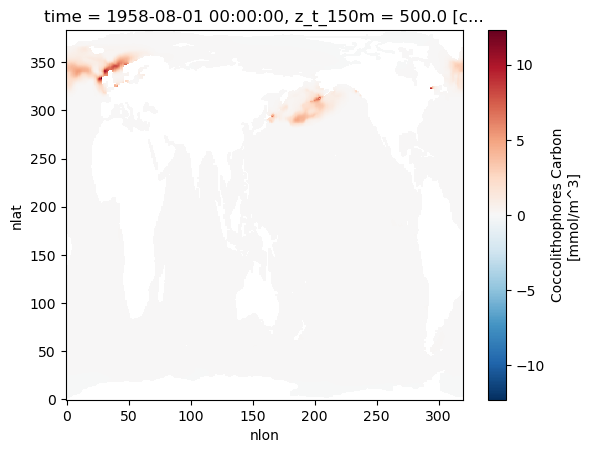

In [9]:
ds.coccoC.isel(time=6,z_t_150m=0).plot()

## Processing - global mean in time

Pull in the functions we defined in the nutrients notebook...

In [10]:
def year_mean(ds):
    """
    Properly convert monthly data to annual means, taking into account month lengths.
    Source: https://ncar.github.io/esds/posts/2021/yearly-averages-xarray/
    """
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.year").sum().values, np.ones((len(ds.groupby("time.year")), )))

    # Calculate the weighted average
    return (ds * weights).groupby("time.year").sum(dim="time")
    

Take the long-term mean of our data set. We process monthly to annual with our custom function, then use xarray's built-in `.mean()` function to process from annual data to a single mean over time, since each year is the same length.

In [11]:
ds_ann = year_mean(ds)

In [12]:
ds = ds_ann.mean("year")

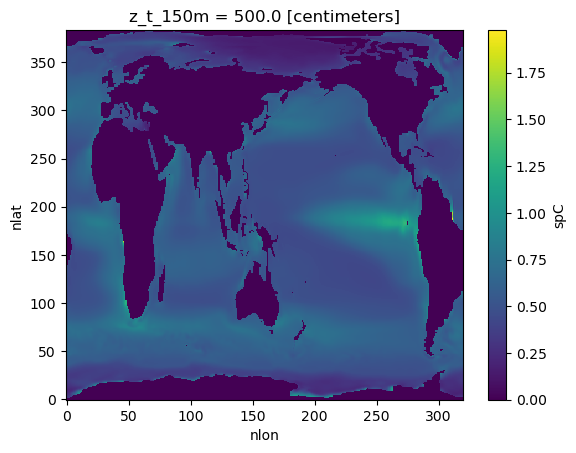

In [13]:
ds['spC'].isel(z_t_150m=0).plot()

## Mapping biomass at different depths
### Phytoplankton biomass at the surface

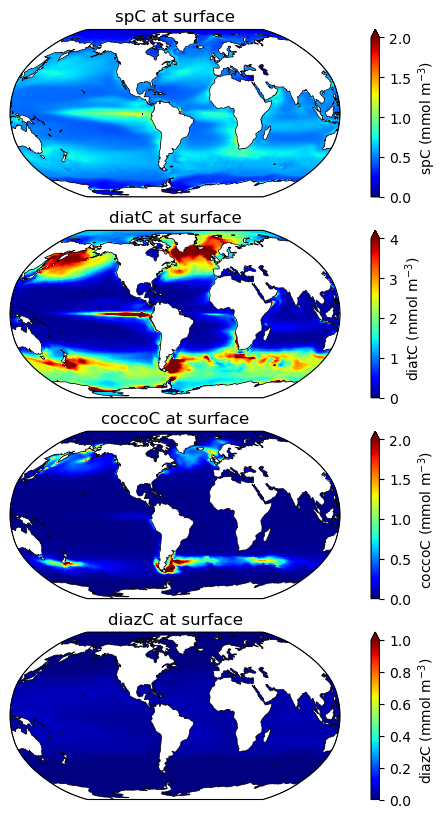

In [14]:
###### 
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)


ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)


ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at surface', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=0))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=1,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

### Phytoplankton biomass at 100m

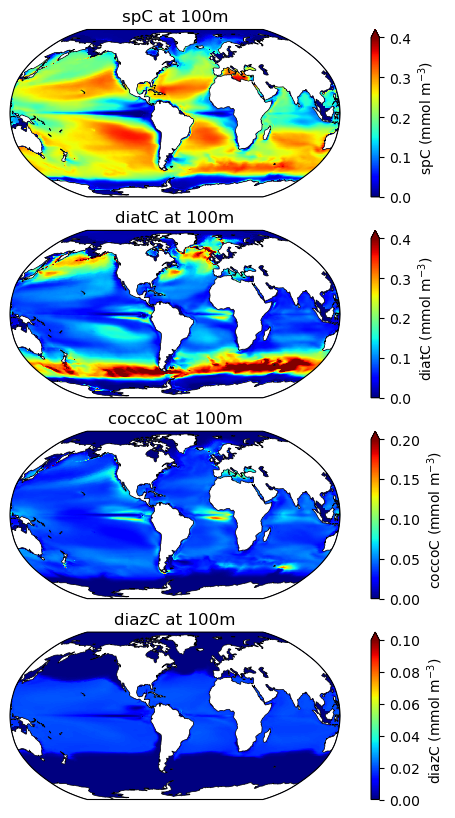

In [15]:
###### 
fig = plt.figure(figsize=(8,10))


ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('spC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.spC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='spC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diatC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diatC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diatC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('coccoC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.coccoC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.2,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='coccoC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('diazC at 100m', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.diazC.isel(z_t_150m=9))
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=0.1,transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diazC (mmol m$^{-3}$)')
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

## Mapping productivity

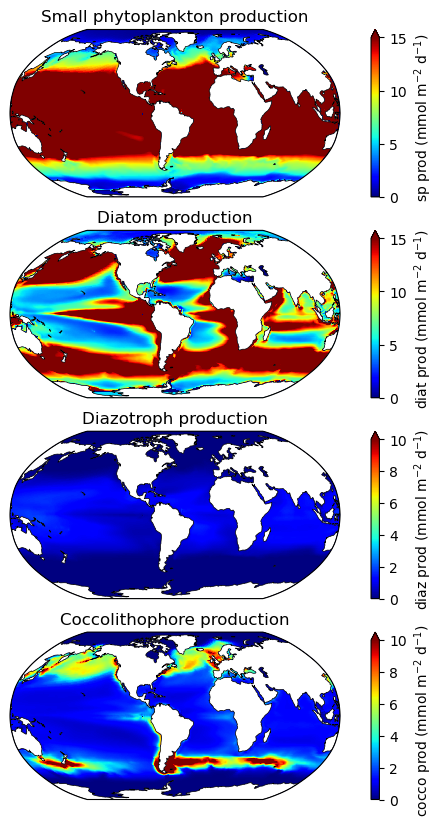

In [16]:
fig = plt.figure(figsize=(8,10))

ax = fig.add_subplot(4,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Small phytoplankton production', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds.photoC_sp_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=15,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='sp prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diatom production', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds.photoC_diat_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=15,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diat prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,3, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Diazotroph production', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds.photoC_diaz_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='diaz prod (mmol m$^{-2}$ d$^{-1}$)')

ax = fig.add_subplot(4,1,4, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Coccolithophore production', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats, ds.photoC_cocco_zint * 864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=10,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)

cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='cocco prod (mmol m$^{-2}$ d$^{-1}$)');

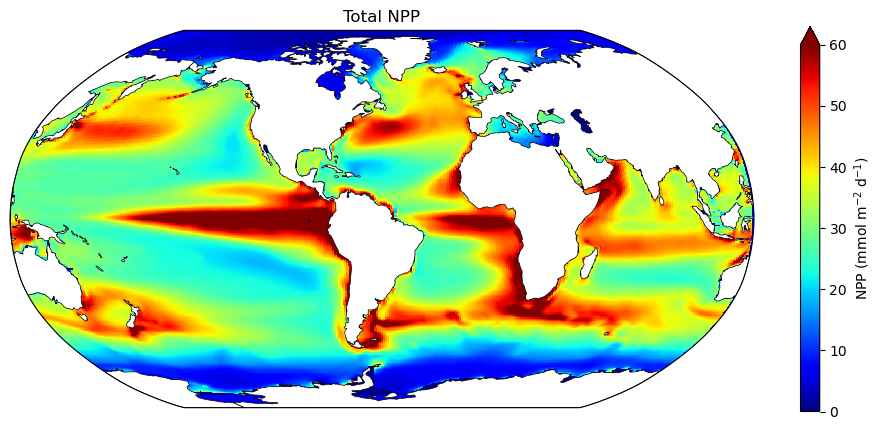

In [17]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Total NPP', fontsize=12)
lon, lat, field = adjust_pop_grid(lons, lats,  ds.photoC_TOT_zint*864.)
pc=ax.pcolormesh(lon, lat, field, cmap='jet',vmin=0,vmax=60,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol m$^{-2}$ d$^{-1}$)');

### Globally integrated NPP

In [18]:
def global_mean(ds, ds_grid, compute_vars, normalize=True, include_ms=False):
    """
    Compute the global mean on a POP dataset. 
    Return computed quantity in conventional units.
    """

    other_vars = list(set(ds.variables) - set(compute_vars))

    if include_ms: # marginal seas!
        surface_mask = ds_grid.TAREA.where(ds_grid.KMT > 0).fillna(0.)
    else:
        surface_mask = ds_grid.TAREA.where(ds_grid.REGION_MASK > 0).fillna(0.)        
    
    masked_area = {
        v: surface_mask.where(ds[v].notnull()).fillna(0.) 
        for v in compute_vars
    }
    
    with xr.set_options(keep_attrs=True):
        
        dso = xr.Dataset({
            v: (ds[v] * masked_area[v]).sum(['nlat', 'nlon'])
            for v in compute_vars
        })
        
        if normalize:
            dso = xr.Dataset({
                v: dso[v] / masked_area[v].sum(['nlat', 'nlon'])
                for v in compute_vars
            })            
                
    return dso

In [19]:
ds_glb = global_mean(ds, ds_grid, variables,normalize=False).compute()

nmols_to_PgCyr = 1e-9 * 12. * 1e-15 * 365. * 86400.

for v in variables:
    ds_glb[v] = ds_glb[v] * nmols_to_PgCyr        
    ds_glb[v].attrs['units'] = 'Pg C yr$^{-1}$'
    
ds_glb

<xarray.Dataset> Size: 580B
Dimensions:            (z_t_150m: 15)
Coordinates:
  * z_t_150m           (z_t_150m) float32 60B 500.0 1.5e+03 ... 1.45e+04
Data variables:
    diatC              (z_t_150m) float64 120B 1.499e+03 1.434e+03 ... 26.18
    coccoC             (z_t_150m) float64 120B 153.9 151.0 141.4 ... 7.402 4.951
    spC                (z_t_150m) float64 120B 765.9 749.4 709.7 ... 59.84 42.14
    diazC              (z_t_150m) float64 120B 35.25 35.11 ... 0.2458 -0.07646
    photoC_TOT_zint    float64 8B 53.16
    photoC_sp_zint     float64 8B 27.68
    photoC_diat_zint   float64 8B 21.22
    photoC_diaz_zint   float64 8B 0.9972
    photoC_cocco_zint  float64 8B 3.269

## Comparing to NPP satellite data

In [20]:
?copernicus_marine.open_dataset

Signature:
copernicus_marine.open_dataset(
    dataset_url: Optional[str] = None,
    dataset_id: Optional[str] = None,
    dataset_version: Optional[str] = None,
    dataset_part: Optional[str] = None,
    username: Optional[str] = None,
    password: Optional[str] = None,
    variables: Optional[List[str]] = None,
    minimum_longitude: Optional[float] = None,
    maximum_longitude: Optional[float] = None,
    minimum_latitude: Optional[float] = None,
    maximum_latitude: Optional[float] = None,
    minimum_depth: Optional[float] = None,
    maximum_depth: Optional[float] = None,
    vertical_dimension_as_originally_produced: bool = True,
    start_datetime: Union[datetime.datetime, str, NoneType] = None,
    end_datetime: Union[datetime.datetime, str, NoneType] = None,
    subset_method: Literal['nearest', 'strict'] = 'nearest',
    service: Optional[str] = None,
    credentials_file: Union[pathlib.Path, str, NoneType] = None,
    overwrite_metadata_cache: bool = False,
    no_meta

In [21]:
ds_sat1 = copernicus_marine.open_dataset( 
    dataset_id = 'cmems_mod_glo_bgc-bio_anfc_0.25deg_P1D-m',
    variables= ['nppv'],
    start_datetime="2021-1-01",
    end_datetime="2021-12-31",
)

ds_sat2 = copernicus_marine.open_dataset( 
    dataset_id = 'cmems_mod_glo_bgc_anfc_0.25deg_static',
    variables= ['cell_thickness'],
    start_datetime="2021-1-01",
    end_datetime="2021-12-31",
)



Fetching catalog: 100%|██████████| 4/4 [00:53<00:00, 13.48s/it]


INFO - 2024-04-02T22:30:30Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-02T22:30:30Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-04-02T22:30:42Z - Service was not specified, the default one was selected: "arco-geo-series"
username:

  rmshkv


password:

  ········


WARNING - 2024-04-02T22:31:55Z - Some or all of your subset selection [2021-01-01 00:00:00, 2021-12-31 00:00:00] for the time dimension  exceed the dataset coordinates [2021-11-01 00:00:00, 2024-04-05 00:00:00]
INFO - 2024-04-02T22:32:00Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-04-02T22:32:00Z - Dataset part was not specified, the first one was selected: "coords"
INFO - 2024-04-02T22:32:00Z - Service was not specified, the default one was selected: "static-arco"
username:

  rmshkv


password:

  ········


In [22]:
ds_sat = xr.merge([ds_sat1, ds_sat2])

In [23]:
ds_sat

<xarray.Dataset> Size: 12GB
Dimensions:    (depth: 50, latitude: 681, longitude: 1440, time: 61)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 3kB -80.0 -79.75 -79.5 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time       (time) datetime64[ns] 488B 2021-11-01 2021-11-02 ... 2021-12-31
Data variables:
    nppv       (time, depth, latitude, longitude) float32 12GB ...
    e3t        (depth) float32 200B ...
Attributes:
    Conventions:                   CF-1.6
    area:                          GLOBAL
    contact:                       https://marine.copernicus.eu/contact
    credit:                        E.U. Copernicus Marine Service Information...
    institution:                   Mercator Ocean
    licence:                       http://marine.copernicus.eu/services-portf...
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    references:                    http://marine.copernicus.eu
    title:                         daily mean fields from Global Ocean Biogeo...

Make a quick map of NPP at the surface for one day - note the eddies visible in this short timespan!

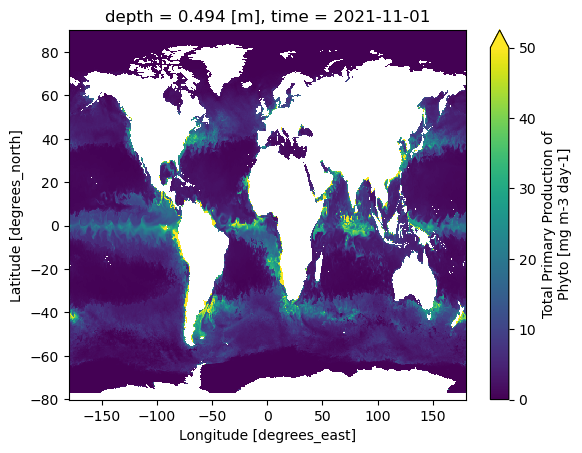

In [24]:
ds_sat.isel(depth=0, time=0).nppv.plot(vmin=0, vmax=50)

### Preliminary processing

In [25]:
ds_sat_tmean = ds_sat.mean("time")

In [26]:
ds_sat_weighted = ds_sat_tmean.nppv * ds_sat_tmean.e3t

In [27]:
ds_sat_weighted

<xarray.DataArray (depth: 50, latitude: 681, longitude: 1440)> Size: 196MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * depth      (depth) float32 200B 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 3kB -80.0 -79.75 -79.5 ... 89.5 89.75 90.0
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8

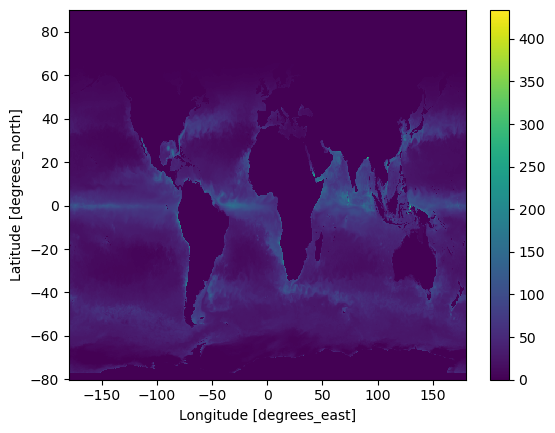

In [28]:
npp_sat = ds_sat_weighted.sum("depth")/12.011
npp_sat.plot()

### Making a comparison map

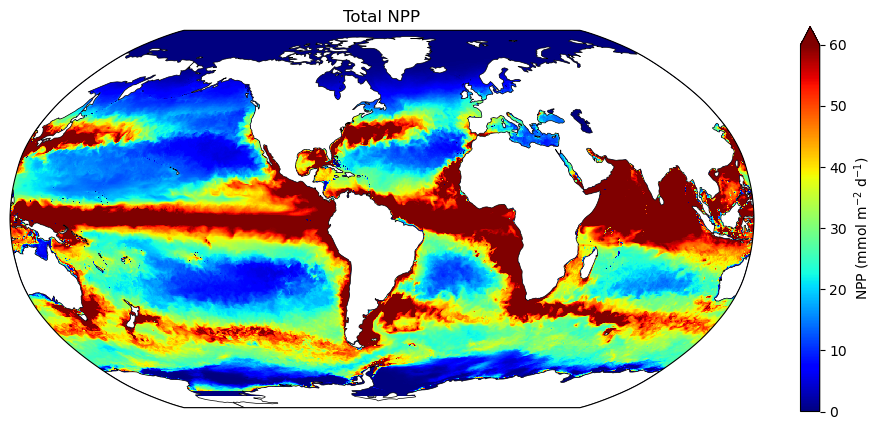

In [29]:
# currently NOT dealing with time correctly, probably not depth either - FIX LATER

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('Total NPP', fontsize=12)
pc=ax.pcolormesh(npp_sat.longitude, npp_sat.latitude, npp_sat, cmap='jet',vmin=0,vmax=60,transform=ccrs.PlateCarree())
land = cartopy.feature.NaturalEarthFeature('physical', 'land', scale='110m', edgecolor='k', facecolor='white', linewidth=0.5)
ax.add_feature(land)
cbar1 = fig.colorbar(pc, ax=ax,extend='max',label='NPP (mmol m$^{-2}$ d$^{-1}$)');

### Maybe take a comparison integral? Need to read in more grid info for this

And close the Dask cluster we spun up at the beginning.

In [30]:
cluster.close()

---

## Summary
You've learned how to take a look at a few quantities related to phytoplankton in CESM.

## Resources and references
Add stuff later.